## ResNext

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    print(e)
    
from IPython.display import Image

In [2]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Activation, Conv2D, Flatten, Dense, \
                                MaxPooling2D, AveragePooling2D, BatchNormalization, add

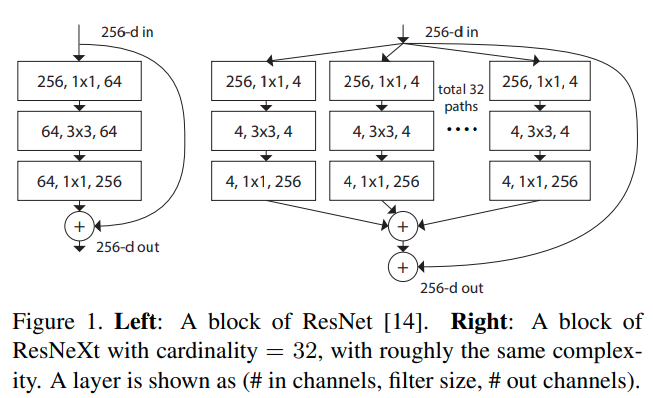

In [3]:
Image('image/resnext_fig1.png')

### ResNet block

In [4]:
def res_conv(filters, kernel_size=3, padding='same', 
             strides=1, activation=True):
    def layer_fn(x):
        x = Conv2D(filters=filters, kernel_size=kernel_size,
                     padding=padding, strides=strides)(x)
        x = BatchNormalization(axis=-1)(x)
        if activation:
            x = Activation('relu')(x)
        return x
    return layer_fn

In [5]:
def merge_with_shortcut():
    def layer_fn(x, x_residual):
        x_shape = tf.keras.backend.int_shape(x)
        x_residual_shape = tf.keras.backend.int_shape(x_residual)
        
        if x_shape == x_residual_shape:
            shortcut = x
        else:
            strides = (
                int(round(x_shape[1] / x_residual_shape[1])), # vertical stride
                int(round(x_shape[2] / x_residual_shape[2])) # horizontal stride    
            )
            x_residual_channels = x_residual_shape[3]
            
            shortcut = Conv2D(
                filters=x_residual_channels, kernel_size=1, 
                padding='valid', strides=strides)(x)
        
        return add([shortcut, x_residual])
    return layer_fn

In [6]:
def resnet_block(filters, kernel_size=3, strides=1,
                name='resnet_block'):
    def layer_fn(x):
        x_residual = res_conv(filters=filters/4, kernel_size=1,
                    padding='valid', strides=strides)(x)
        x_residual = res_conv(filters=filters/4, kernel_size=kernel_size,
                    padding='same', strides=1)(x_residual)
        x_residual = res_conv(filters=filters, kernel_size=1,
                    padding='valid', strides=1, activation=False)(x_residual)
        x = merge_with_shortcut()(x, x_residual)
        x = Activation('relu')(x)
        return x
    return layer_fn

### ResNext block

In [7]:
def resnext_block(filters, kernel_size=3, strides=1,
                 name='resnext_block'):
    def layer_fn(x):
        residual_groups = []
        for _ in range(32):
            x_residual = res_conv(filters=4, kernel_size=1,
                        padding='valid', strides=strides)(x)
            x_residual = res_conv(filters=4, kernel_size=kernel_size,
                        padding='same', strides=1)(x_residual)
            x_residual = res_conv(filters=filters, kernel_size=1,
                        padding='valid', strides=1, activation=False)(x_residual)
            residual_groups.append(x_residual)
        
        x_residual = add(residual_groups)
        x = merge_with_shortcut()(x, x_residual)
        x = Activation('relu')(x)
        return x
    return layer_fn

In [8]:
def resnext_block_example(input_shape, num_classes):
    input = Input(shape=input_shape)
    x = resnext_block(256)(input)
    x = Flatten()(x)
    output = Dense(num_classes, activation='softmax', name='output')(x)
    model = Model(inputs=input, outputs=output)
    
    return model

In [9]:
num_classes = 10
input_shape = [32, 32, 256]
batch_input_shape = tf.TensorShape((None, *input_shape))

In [10]:
model = resnext_block_example(input_shape, num_classes)
model.build(input_shape=batch_input_shape)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 256  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 4)    1028        ['input_1[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 32, 32, 4)    1028        ['input_1[0][0]']                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 32, 32, 4)    1028        ['input_1[0][0]']            

In [12]:
dot_img_file = 'ResNext_block_example.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True, rankdir='LR')